# 学習と評価
 - 二値分類モデルの並列を行い，マルチラベル問題を解く

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.8.0'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
from sklearn.model_selection import KFold

## データのロード

- 画像サイズは224×224

In [7]:
df = pd.read_csv("data1_union.csv")

In [8]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,272998,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,1.0,1.0,1.0,1.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,1.0,1.0,0.0,1.0,1.0,0.0,0.0
83,124821,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [9]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    img_raw = tf.io.read_file(path)
    img_tensor = tf.image.decode_image(img_raw)
    img_final = tf.image.resize(img_tensor, [224, 224])
    img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_final)
    X.append(img_preprocessed)

In [10]:
X = np.array(X)

## モデル構築

In [11]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [12]:
vgg16 = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [13]:
vgg16.output_shape

(None, 7, 7, 512)

In [14]:
def get_top():
    input_ts = Input(shape=vgg16.output_shape[1:])
    flat = Flatten()(input_ts)
    dense1 = Dense(256, activation="relu")(flat)
    dropout1 = Dropout(0.5)(dense1)
    final = Dense(2, activation="softmax")(dropout1)
    model = Model(
            inputs=[input_ts],
            outputs=[final]
        )
    return model

In [15]:
def get_binary_model(fine=False):
    model = Model(
        inputs=vgg16.input,
        outputs=get_top()(vgg16.output)
    )
    # 転移学習の場合
    for layer in model.layers[:19]:
        layer.trainable = fine
    return model

### まずは一つのラベルでテストする

In [16]:
# まずはconfidentでやってみる
y_raw = df["Confident"]
y = tf.keras.utils.to_categorical(y_raw)

In [17]:
model = get_binary_model()

In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [21]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)

In [22]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [23]:
from sklearn.metrics import f1_score

In [388]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal", seed=1001),
  RandomRotation(0.2, seed=1001),
])

In [389]:
accs = []
f1s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_sk = np.argmax(y_test, axis=1)
    
    neg = y_train.sum(axis=0)[0]
    pos = y_train.sum(axis=0)[1]
    total = pos + neg
    print(f"origin pos:{pos} neg:{neg}")
    
    rate = int(neg / pos / 2)
    add_data = []
    add_cnt = 0
    for i,v in enumerate(y_test_sk):
        if v == 1:
            for j in range(rate):
                img = data_augmentation(X_train[i], training=True)
                add_data.append(img)
                add_cnt += 1
    add_data = np.array(add_data)
    print(add_cnt)
    X_train_arg = np.concatenate([X_train, add_data])
    y_train_arg = np.concatenate([y_train, tf.keras.utils.to_categorical([1 for v in range(add_cnt)])])
    
    neg_arg = y_train_arg.sum(axis=0)[0]
    pos_arg = y_train_arg.sum(axis=0)[1]
    total_arg = pos_arg + neg_arg
    print(f"after pos:{pos_arg} neg:{neg_arg}")
    
    """
    # 初期重みの最適化
    initial_bias = np.log([neg/pos])
    model.layers[-1].bias_initializer=initial_bias
    
    # クラスの重み
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print(class_weight)
    """
    
    #model.fit(X_train, y_train, batch_size=1, epochs=20, class_weight=class_weight)
    model.fit(X_train_arg, y_train_arg, batch_size=1, epochs=5)
    y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)
    print("Predict:", y_pred)
    print("True:", y_test_sk)
    f1 = f1_score(y_test_sk, y_pred, average="binary")
    print("F1 score:", f1)
    f1s.append(f1)
    accs.append(model.evaluate(X_test, y_test, batch_size=1))

origin pos:2.0 neg:54.0
13
after pos:15.0 neg:54.0
Epoch 1/5
69/69 [==============================] - 2s 24ms/step - loss: 0.6569 - tp: 54.0000 - fp: 15.0000 - tn: 54.0000 - fn: 15.0000 - accuracy: 0.7826 - precision: 0.7826 - recall: 0.7826 - auc: 0.8021
Epoch 2/5
69/69 [==============================] - 2s 24ms/step - loss: 0.6489 - tp: 54.0000 - fp: 15.0000 - tn: 54.0000 - fn: 15.0000 - accuracy: 0.7826 - precision: 0.7826 - recall: 0.7826 - auc: 0.7387
Epoch 3/5
69/69 [==============================] - 2s 24ms/step - loss: 0.6410 - tp: 54.0000 - fp: 15.0000 - tn: 54.0000 - fn: 15.0000 - accuracy: 0.7826 - precision: 0.7826 - recall: 0.7826 - auc: 0.7761
Epoch 4/5
69/69 [==============================] - 2s 24ms/step - loss: 0.6338 - tp: 54.0000 - fp: 15.0000 - tn: 54.0000 - fn: 15.0000 - accuracy: 0.7826 - precision: 0.7826 - recall: 0.7826 - auc: 0.7879
Epoch 5/5
69/69 [==============================] - 2s 24ms/step - loss: 0.6271 - tp: 54.0000 - fp: 15.0000 - tn: 54.0000 - fn: 15

## すべてのラベルでやってみる

In [24]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [25]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [26]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [42]:
f1_dict = dict()
for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)
        model.fit(X_train, y_train, batch_size=8, epochs=5, class_weight=class_weight)
        y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
    

Caring
Epoch 1/5
7/7 [==============================] - 2s 38ms/step - loss: 10.7637 - tp: 83.0000 - fp: 30.0000 - tn: 83.0000 - fn: 30.0000 - accuracy: 0.7345 - precision: 0.7345 - recall: 0.7345 - auc: 0.7354
Epoch 2/5
7/7 [==============================] - 0s 37ms/step - loss: 3.5312 - tp: 51.0000 - fp: 5.0000 - tn: 51.0000 - fn: 5.0000 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9107
Epoch 3/5
7/7 [==============================] - 0s 37ms/step - loss: 1.3280 - tp: 55.0000 - fp: 1.0000 - tn: 55.0000 - fn: 1.0000 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978
Epoch 4/5
7/7 [==============================] - 0s 37ms/step - loss: 0.3243 - tp: 55.0000 - fp: 1.0000 - tn: 55.0000 - fn: 1.0000 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9821 
Epoch 5/5
7/7 [==============================] - 0s 38ms/step - loss: 0.2398 - tp: 56.0000 - fp: 0.0000e+00 - tn: 56.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recal

8/8 [==============================] - 1s 36ms/step - loss: 12.0661 - tp: 85.0000 - fp: 28.0000 - tn: 85.0000 - fn: 28.0000 - accuracy: 0.7522 - precision: 0.7522 - recall: 0.7522 - auc: 0.7784
Epoch 2/5
8/8 [==============================] - 0s 35ms/step - loss: 3.9044 - tp: 49.0000 - fp: 8.0000 - tn: 49.0000 - fn: 8.0000 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.8867
Epoch 3/5
8/8 [==============================] - 0s 36ms/step - loss: 2.2662 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9821 
Epoch 4/5
8/8 [==============================] - 0s 35ms/step - loss: 3.4712 - tp: 54.0000 - fp: 3.0000 - tn: 54.0000 - fn: 3.0000 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9474
Epoch 5/5
8/8 [==============================] - 0s 35ms/step - loss: 0.6194 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9825  

8/8 [==============================] - 1s 34ms/step - loss: 13.2270 - tp: 82.0000 - fp: 32.0000 - tn: 82.0000 - fn: 32.0000 - accuracy: 0.7193 - precision: 0.7193 - recall: 0.7193 - auc: 0.7332
Epoch 2/5
8/8 [==============================] - 0s 35ms/step - loss: 7.7771 - tp: 48.0000 - fp: 9.0000 - tn: 48.0000 - fn: 9.0000 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.8393
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 3.7245 - tp: 55.0000 - fp: 2.0000 - tn: 55.0000 - fn: 2.0000 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9643  
Epoch 4/5
8/8 [==============================] - 0s 35ms/step - loss: 0.8724 - tp: 56.0000 - fp: 1.0000 - tn: 56.0000 - fn: 1.0000 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9825
Epoch 5/5
8/8 [==============================] - 0s 36ms/step - loss: 0.5914 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc:

In [43]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))

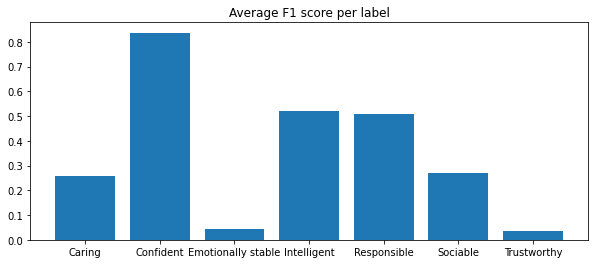

In [44]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title("Average F1 score per label")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない=>unionに変えたら多少ましになった
 - 役に立たない　やはりデータが少なすぎるか